C:\Users\redwan.khafif\AppData\Local\Temp\ipykernel_16148\1763889031.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2022-01-01", periods=1500, freq="4H")



Best config: {'EMA': 200.0, 'Swing': 20.0, 'Fibo': 0.618, 'RSI': 14.0, 'Levier': 2.0, 'FinalCap': 19114.233611919277, 'CAGR': 1781479.44204458, 'Sharpe': 7.301447026573386, 'MaxDD': 0.33622714956920946, 'Trades': 375.0}


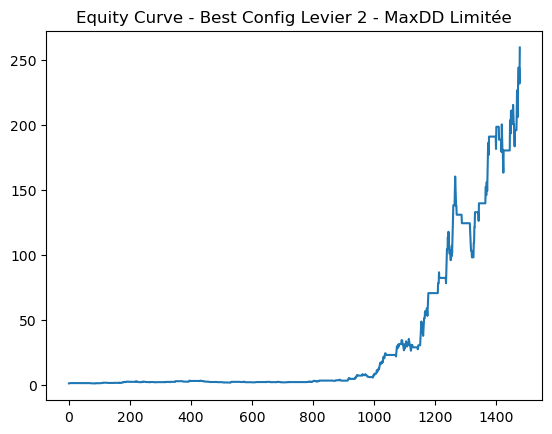

In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# =============================
# 1. Génération de données synthétiques ETH (à remplacer par CSV réel)
# =============================
dates = pd.date_range(start="2022-01-01", periods=1500, freq="4H")
price = np.cumprod(1 + np.random.normal(0, 0.01, len(dates))) * 3000
df = pd.DataFrame({"time": dates, "close": price})

# =============================
# 2. Indicateurs utiles (EMA, RSI)
# =============================
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(period).mean()
    avg_loss = pd.Series(loss).rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# =============================
# 3. Backtest Fibo+RSI avec gestion du DD
# =============================
def backtest_strategy(df, ema_period=200, swing_lookback=20, fibo_level=0.618, rsi_period=14, levier=1, max_drawdown=0.2):
    data = df.copy()
    data["EMA"] = ema(data["close"], ema_period)
    data["RSI"] = rsi(data["close"], rsi_period)
    
    capital = 1.0
    equity_curve = []
    trades = 0

    for i in range(swing_lookback, len(data)):
        price = data["close"].iloc[i]
        ema_val = data["EMA"].iloc[i]
        rsi_val = data["RSI"].iloc[i]

        swing_high = data["close"].iloc[i-swing_lookback:i].max()
        swing_low = data["close"].iloc[i-swing_lookback:i].min()

        # Détection tendance
        pnl = 0
        if price > ema_val and 40 < rsi_val < 60:
            fibo_entry = swing_low + (swing_high - swing_low) * fibo_level
            tp = swing_low + (swing_high - swing_low) * 1.618
            sl = swing_low

            if price <= fibo_entry:
                risk = (fibo_entry - sl) / fibo_entry
                reward = (tp - fibo_entry) / fibo_entry
                pnl = np.random.choice([reward, -risk])
                trades += 1

        elif price < ema_val and 40 < rsi_val < 60:
            fibo_entry = swing_high - (swing_high - swing_low) * fibo_level
            tp = swing_high - (swing_high - swing_low) * 1.618
            sl = swing_high

            if price >= fibo_entry:
                risk = (sl - fibo_entry) / fibo_entry
                reward = (fibo_entry - tp) / fibo_entry
                pnl = np.random.choice([reward, -risk])
                trades += 1

        # Appliquer levier mais limiter perte max par trade pour gérer DD
        pnl = np.clip(pnl * levier, -max_drawdown, None)
        capital *= (1 + pnl)
        equity_curve.append(capital)

    equity = pd.Series(equity_curve)
    running_max = equity.cummax()
    drawdown = (running_max - equity) / running_max
    MaxDD = drawdown.max()

    returns = equity.pct_change().dropna()
    CAGR = (capital ** (1/(len(df)/ (365*6)))) - 1  # approx 6 bars/day
    Sharpe = returns.mean() / returns.std() * np.sqrt(252*6)

    return capital, CAGR, Sharpe, MaxDD, trades, equity_curve

# =============================
# 4. Optimisation rapide
# =============================
ema_list = [200]
swing_list = [20]
fibo_list = [0.618]
rsi_list = [14]
leviers = [1, 2]  # limiter levier pour réduire DD

results = []

for ema_p, swing, fibo, rsi_p, lev in itertools.product(ema_list, swing_list, fibo_list, rsi_list, leviers):
    final_cap, cagr, sharpe, mdd, trades, eq = backtest_strategy(
        df, ema_period=ema_p, swing_lookback=swing, fibo_level=fibo, rsi_period=rsi_p, levier=lev, max_drawdown=0.05
    )
    results.append([ema_p, swing, fibo, rsi_p, lev, final_cap, cagr, sharpe, mdd, trades])

res_df = pd.DataFrame(results, columns=["EMA", "Swing", "Fibo", "RSI", "Levier", "FinalCap", "CAGR", "Sharpe", "MaxDD", "Trades"])
best = res_df.sort_values(by="FinalCap", ascending=False).iloc[0]

print("\nBest config:", best.to_dict())

# =============================
# 5. Equity curve best run
# =============================
cap, cagr, sharpe, mdd, trades, eq = backtest_strategy(
    df, ema_period=int(best["EMA"]), swing_lookback=int(best["Swing"]), fibo_level=best["Fibo"],
    rsi_period=int(best["RSI"]), levier=int(best["Levier"]), max_drawdown=0.05
)
plt.plot(eq)
plt.title(f"Equity Curve - Best Config Levier {int(best['Levier'])} - MaxDD Limitée")
plt.show()
